## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date тип object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
# ваш код здесь
data['date'] = pd.to_datetime(data['date'])

data.groupby(['group'])['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


A/B тест проводился со 2 по 24 января 2021 года

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
# ваш код здесь
data.groupby(['group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})

,user_id,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
# ваш код здесь
users_a = set()
for i in data[data['group']=='A']['user_id']:
    users_a.add(i)
users_b = set()
for i in data[data['group']=='B']['user_id']:
    users_b.add(i)
user_intersection = users_a.intersection(users_b)
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

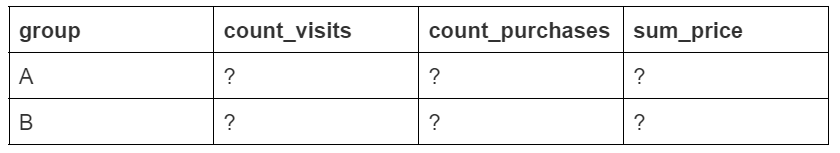
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
# ваш код здесь
new_data = updated_data.groupby(['group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})\
    .rename(columns={'user_id':'count_visits', 'purchase':'count_purchase', 'price':'sum_price'})
new_data

,count_visits,count_purchase,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Выводы: по построенной таблице можно сказать, что данные вполне сопоставимые и представлены адекватными величинами. Выборка достаточно сбалансированная - различия между показателями в группах настолько малые, что трудно навскидку сделать вывод об эффективности продукта В. Следовательно продолжение исследования оправдано. Таблица очищена от пересечений межу группами и готова к дальнейшему анализу.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
# ваш код здесь
new_data['conversion'] = round(new_data['count_purchase']/new_data['count_visits']*100, 2)
new_data['mean_check'] = round(new_data['sum_price']/new_data['count_purchase'])
new_data

,count_visits,count_purchase,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Вывод: по данной таблице видно, что показатель конверсии в группе А выше, чем в группе В. В то же время по размеру среднего чека вариант В представляется более эффективным.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
# ваш код здесь
piv_purchase = updated_data.pivot_table(values='purchase', index='price', columns='group', aggfunc='sum', fill_value=0)
piv_purchase

group,A,B
price,,
0,0,0
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [11]:
# ваш код здесь
heatmap = px.imshow(piv_purchase, text_auto=True, title='Количество продаж в зависимости от стоимости тура по группам А/В')
heatmap

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Вывод: в группе А наибольшее количество продаж приходится на туры стоимостью 10000 и 60000 рублей. Покупательская способность участников группы В выше: помимо самых дешевых туров, количество приобретенных туров стоимостью 100000 значительно превалирует над количеством аналогичных туров, купленных участниками группы А. Количество самых дорогих туров примерно одинаковое между группами.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
# ваш код здесь
daily_data = updated_data.groupby(['date', 'group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})
daily_data['conversion'] = round(daily_data['purchase']/daily_data['user_id']*100, 2)
daily_data['mean_check'] = round(daily_data['price']/daily_data['purchase'])
daily_data

user_id  purchase     price  conversion  mean_check
date       group                                                     
2021-01-02 A         2854       359  29410000       12.58     81922.0
           B         2861       345  29660000       12.06     85971.0
2021-01-03 A         6596       748  62000000       11.34     82888.0
           B         6619       754  65960000       11.39     87480.0
2021-01-04 A         6566       799  64250000       12.17     80413.0
           B         6536       764  68030000       11.69     89045.0
2021-01-05 A         6433       790  64550000       12.28     81709.0
           B         6511       749  63550000       11.50     84846.0
2021-01-06 A         6606       764  63410000       11.57     82997.0
           B         6751       838  75020000       12.41     89523.0
2021-01-07 A         6579       795  67290000       12.08     84642.0
           B         6616       767  67170000       11.59     87575.0
2021-01-08 A         6687       798  65380000       11.93     81930.0
           B         6714       812  71270000       12.09     87771.0
2021-01-09 A         6633       794  65610000       11.97     82632.0
           B         6628       784  71410000       11.83     91084.0
2021-01-10 A         6659       759  58950000       11.40     77668.0
           B         6701       846  78080000       12.62     92293.0
2021-01-11 A         6699       797  58760000       11.90     73726.0
           B         6679       770  66960000       11.53     86961.0
2021-01-12 A         6540       795  68460000       12.16     86113.0
           B         6635       807  70560000       12.16     87435.0
2021-01-13 A         6564       764  63590000       11.64     83233.0
           B         6495       720  65910000       11.09     91542.0
2021-01-14 A         6543       825  65890000       12.61     79867.0
           B         6608       792  68990000       11.99     87109.0
2021-01-15 A         6701       806  67570000       12.03     83834.0
           B         6563       747  69160000       11.38     92584.0
2021-01-16 A         6601       808  66210000       12.24     81943.0
           B         6544       786  70560000       12.01     89771.0
2021-01-17 A         6619       809  63020000       12.22     77899.0
           B         6546       831  75300000       12.69     90614.0
2021-01-18 A         6511       812  62850000       12.47     77401.0
           B         6603       822  72240000       12.45     87883.0
2021-01-19 A         6582       790  63680000       12.00     80608.0
           B         6562       772  67820000       11.76     87850.0
2021-01-20 A         6533       749  58710000       11.46     78385.0
           B         6685       790  69250000       11.82     87658.0
2021-01-21 A         6750       851  70300000       12.61     82609.0
           B         6555       760  69870000       11.59     91934.0
2021-01-22 A         6587       788  63690000       11.96     80825.0
           B         6659       787  68660000       11.82     87243.0
2021-01-23 A         6698       843  70950000       12.59     84164.0
           B         6633       805  68930000       12.14     85627.0
2021-01-24 A         3766       444  33250000       11.79     74887.0
           B         3677       442  38650000       12.02     87443.0

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
# ваш код здесь
daily_data['cum_visits'] = daily_data.groupby(['group'])['user_id'].cumsum()
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase'].cumsum()
daily_data['cum_price'] = daily_data.groupby(['group'])['price'].cumsum()
daily_data['cum_conversion'] = round(daily_data['cum_purchase']/daily_data['cum_visits']*100, 2)
daily_data['cum_check'] = round(daily_data['cum_price']/daily_data['cum_purchase'])
daily_data

user_id  purchase     price  conversion  mean_check  \
date       group                                                        
2021-01-02 A         2854       359  29410000       12.58     81922.0   
           B         2861       345  29660000       12.06     85971.0   
2021-01-03 A         6596       748  62000000       11.34     82888.0   
           B         6619       754  65960000       11.39     87480.0   
2021-01-04 A         6566       799  64250000       12.17     80413.0   
           B         6536       764  68030000       11.69     89045.0   
2021-01-05 A         6433       790  64550000       12.28     81709.0   
           B         6511       749  63550000       11.50     84846.0   
2021-01-06 A         6606       764  63410000       11.57     82997.0   
           B         6751       838  75020000       12.41     89523.0   
2021-01-07 A         6579       795  67290000       12.08     84642.0   
           B         6616       767  67170000       11.59     87575.0   
2021-01-08 A         6687       798  65380000       11.93     81930.0   
           B         6714       812  71270000       12.09     87771.0   
2021-01-09 A         6633       794  65610000       11.97     82632.0   
           B         6628       784  71410000       11.83     91084.0   
2021-01-10 A         6659       759  58950000       11.40     77668.0   
           B         6701       846  78080000       12.62     92293.0   
2021-01-11 A         6699       797  58760000       11.90     73726.0   
           B         6679       770  66960000       11.53     86961.0   
2021-01-12 A         6540       795  68460000       12.16     86113.0   
           B         6635       807  70560000       12.16     87435.0   
2021-01-13 A         6564       764  63590000       11.64     83233.0   
           B         6495       720  65910000       11.09     91542.0   
2021-01-14 A         6543       825  65890000       12.61     79867.0   
           B         6608       792  68990000       11.99     87109.0   
2021-01-15 A         6701       806  67570000       12.03     83834.0   
           B         6563       747  69160000       11.38     92584.0   
2021-01-16 A         6601       808  66210000       12.24     81943.0   
           B         6544       786  70560000       12.01     89771.0   
2021-01-17 A         6619       809  63020000       12.22     77899.0   
           B         6546       831  75300000       12.69     90614.0   
2021-01-18 A         6511       812  62850000       12.47     77401.0   
           B         6603       822  72240000       12.45     87883.0   
2021-01-19 A         6582       790  63680000       12.00     80608.0   
           B         6562       772  67820000       11.76     87850.0   
2021-01-20 A         6533       749  58710000       11.46     78385.0   
           B         6685       790  69250000       11.82     87658.0   
2021-01-21 A         6750       851  70300000       12.61     82609.0   
           B         6555       760  69870000       11.59     91934.0   
2021-01-22 A         6587       788  63690000       11.96     80825.0   
           B         6659       787  68660000       11.82     87243.0   
2021-01-23 A         6698       843  70950000       12.59     84164.0   
           B         6633       805  68930000       12.14     85627.0   
2021-01-24 A         3766       444  33250000       11.79     74887.0   
           B         3677       442  38650000       12.02     87443.0   

                  cum_visits  cum_purchase   cum_price  cum_conversion  \
date       group                                                         
2021-01-02 A            2854           359    29410000           12.58   
           B            2861           345    29660000           12.06   
2021-01-03 A            9450          1107    91410000           11.71   
           B            9480          1099    95620000           11.59   
2021-01-04 A           16016          1906   155660000           11.9

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

Text(0.5, 1.0, 'Кумулятивный график среднего чека по группам')

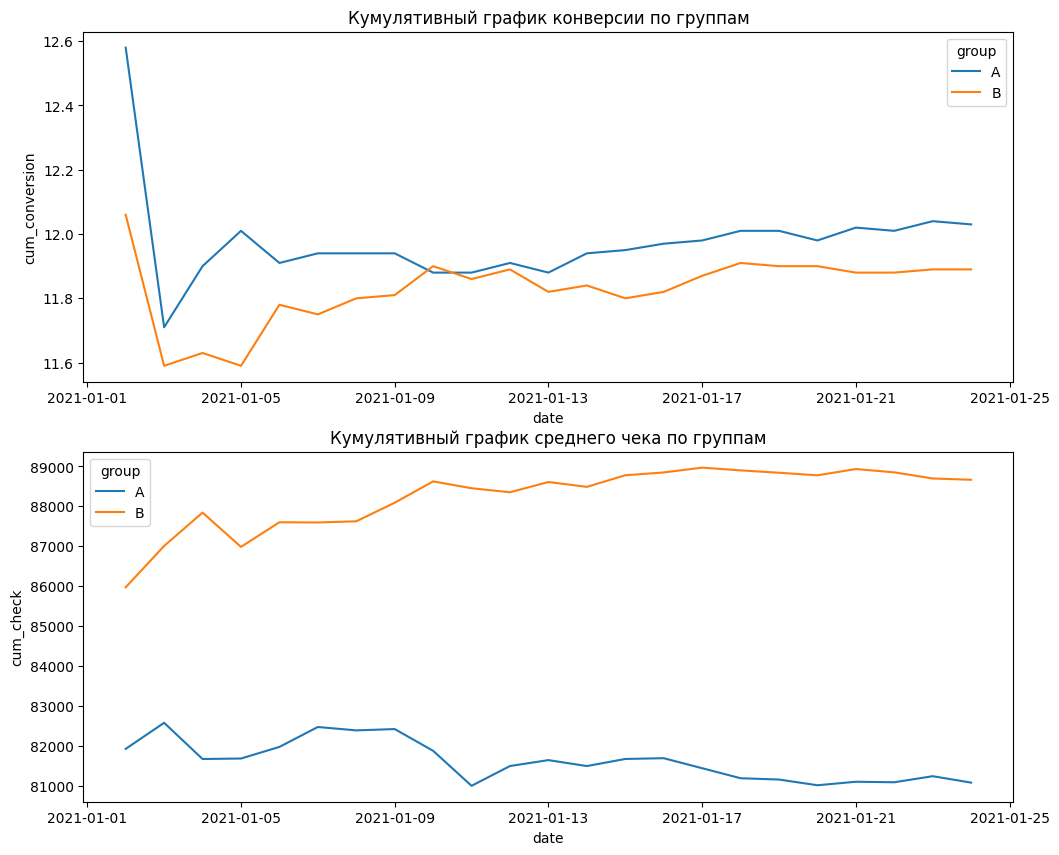

In [14]:
# ваш код здесь
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.lineplot(data=daily_data, x='date', y='cum_conversion', hue='group', ax=axes[0])
sns.lineplot(data=daily_data, x='date', y='cum_check', hue='group', ax=axes[1] )
axes[0].set_title('Кумулятивный график конверсии по группам')
axes[1].set_title('Кумулятивный график среднего чека по группам')

Вывод: на данных графиках мы видим сильные колебания в начале тестирования и плавную стабилизацию в процессе. 

График конверсий стабилизировался после 13 января и можно с уверенностью сказать, что на протяжении всего времени группа В имеет меньшую конверсию, чем группа А. 

График среднего чека отличается большей плавностью, однако тут тоже можно отметить более резкие перепады со 2 по 11 января, сменяющиеся относительно ровными линиями.

Сам факт стабилизации графиков говорит о том, что длительность тестирования была достаточной и его можно считать завершенным.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
# ваш код здесь
purchase_piv = updated_data.groupby(['group'])['purchase'].agg(['sum', 'count'])

H0 = 'Конверсии в группах А и В равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе В'
alpha = 0.05

_,p_value = proportions_ztest(count=purchase_piv['sum'], nobs=purchase_piv['count'], alternative='larger')
print('p-value:', round(p_value, 2))

if p_value<alpha:
    print('Отвергаем нулевую гипотезу. {}'.format(H1))
else:
    print('Принимаем нулевую гипотезу: {}'.format(H0))

p-value: 0.12
Принимаем нулевую гипотезу: Конверсии в группах А и В равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Вывод: по проведенному Z-тесту можно сказать, что результаты являются статистически незначимыми и опровергнуть нулевую гипотезу о равенстве конверсий не представляется возможным.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
# ваш код здесь
a_data = updated_data[updated_data['group']=='A']
b_data = updated_data[updated_data['group']=='B']

def prop_conf_int(n, xp, gamma):
    alpha = 1-gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit*(xp*(1-xp)/n)**0.5
    lower_bound = xp-eps
    upper_bound = xp+eps
    return round(lower_bound*100, 2), round(upper_bound*100, 2)

conf_interval_a = prop_conf_int(n=a_data['user_id'].count(), xp=a_data['purchase'].mean(), gamma=0.95)
conf_interval_b = prop_conf_int(n=b_data['user_id'].count(), xp=b_data['purchase'].mean(), gamma=0.95)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [17]:
def diff_prop_conf_int(n, xp, gamma):
    alpha = 1 - gamma 
    diff = xp[1] - xp[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
    lower_bound = diff - eps
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
gamma = 0.95

diff_inverval = diff_prop_conf_int(n, xp, gamma)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Вывод: получив значения доверительных интервалов конверсий, мы увидели их пересечение. Это значит, что нельзя однозначно сказать, есть ли разница в конверсиях. Для этого был вычислен доверительный интервал разности конверсий. Результат охватывает точку ноль, а следовательно вариант А и вариант В являются равнозначными по метрике конверсии.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [18]:
data_a = updated_data[updated_data['group']=='A']
daily_data_a = data_a.groupby(['date']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})
daily_data_a['mean_check'] = round(daily_data_a['price']/daily_data_a['purchase'])

data_b = updated_data[updated_data['group']=='B']
daily_data_b = data_b.groupby(['date']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})
daily_data_b['mean_check'] = round(daily_data_b['price']/daily_data_b['purchase'])

In [19]:
# ваш код здесь
H0 = 'Распределение нормальное'
H1 = 'Распределение отлично от нормального'
alpha = 0.05
shapiro_a = shapiro(daily_data_a['mean_check'])
shapiro_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А:', round(shapiro_a.pvalue, 2))
print('p-value группы В:', round(shapiro_b.pvalue, 2))
if shapiro_a.pvalue<alpha or shapiro_b.pvalue<alpha:
    print('Отвергаем нулевую гипотезу. {}'.format(H1))
else:
    print('Принимаем нулевую гипотезу: {}'.format(H0))
    

p-value группы А: 0.25
p-value группы В: 0.09
Принимаем нулевую гипотезу: Распределение нормальное


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [20]:
# ваш код здесь
H0 = 'Ежедневные средние чеки в группах А и В равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе В'
alpha = 0.05

results = ttest_ind(a=daily_data_a['mean_check'], b=daily_data_b['mean_check'], alternative='less')
print('p-value: ', results.pvalue)
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу. {}'.format(H1))
else:
    print('Принимаем нулевую гипотезу: {}'.format(H0))

p-value:  1.1275579271768679e-12
Отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше, чем в группе В


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Вывод: По причине нормального распределения величины ежедневного среднего чека в группах был выбран t-тест для их сравнения. Тестирование подтвердило альтернативную гипотезу и показало, что ежедневный средний чек в группе А меньше.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [21]:
round(daily_data_a['mean_check'].describe())

count       23.0
mean     80969.0
std       3096.0
min      73726.0
25%      79126.0
50%      81922.0
75%      82942.0
max      86113.0
Name: mean_check, dtype: float64

In [22]:
n = 23
k= n-1
x_mean = 80969
x_std = 3096
gamma = 0.95
alpha = 1- gamma

t_crit = -t.ppf(alpha/2, k)

eps = t_crit*x_std/(n**0.5)
lower_bound = round(x_mean - eps)
upper_bound = round(x_mean + eps)
conf_interval = (round(lower_bound), round(upper_bound))
print('Доверительный интервал среднего чека для группы А: {}'.format(conf_interval))

Доверительный интервал среднего чека для группы А: (79630, 82308)


In [23]:
round(daily_data_b['mean_check'].describe())

count       23.0
mean     88576.0
std       2197.0
min      84846.0
25%      87339.0
50%      87771.0
75%      90192.0
max      92584.0
Name: mean_check, dtype: float64

In [24]:
n = 23
k= n-1
x_mean = 88576
x_std = 2197
gamma = 0.95
alpha = 1- gamma

t_crit = -t.ppf(alpha/2, k)

eps = t_crit*x_std/(n**0.5)
lower_bound = round(x_mean - eps)
upper_bound = round(x_mean + eps)
conf_interval = (round(lower_bound), round(upper_bound))
print('Доверительный интервал среднего чека для группы B: {}'.format(conf_interval))

Доверительный интервал среднего чека для группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы для средних чеков в группах не имеют пересечений по значениям. Это значит, что истинный средний чек в группе А и группе В совпасть (быть одинаковым) не может. Это опровергает нулевую гипотезу об отсутствии разницы между группами по этому показателю.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

В процессе анализа результатов А/В тестирования были проведены визуальное сравнение метрик, статистические тесты с заданным уровнем значимости, а также найдены доверительные интервалы для метрик с заданным уровнем надежности.

Метриками выступили ежедневные конверсия пользователей и средний чек. Визуальная оценка метрик показала, что конверсия в группе А выше, однако средний чек выше в группе В. Исследование покупательской способности показало, что пользователи из группы В активно покупают более дорогие туры, чем в группе А.

Далее были построены кумулятивные графики по метрикам. В целом, они показали ту же картину: конверсия выше в группе А, а средний чек - в группе В. Однако разница конверсии невелика в то время, как размер чека идет с большим отрывом. Также графики показали стабилизацию показателей во времени, что говорит о завершенности тестирования.

Статистические тесты. 

Конверсии исследовались с помощью z-теста, результаты которого показали, что статистической разницы по этой метрике между группами нет, и невозможно опровергнуть нулевую гипотезу о равенстве конверсий в группах. В дополнение к тесту были посчитаны доверительные интервалы для каждой группы. Доверительные интервалы показали пересечение, в связи с чем был посчитан доверительный интервал разности конверсий. Он показал, что между вариантами А и В нет статистической разницы в конверсии. 

Исследование метрики ежедневного среднего чека в группах дало следующие результаты: в связи с нормальным распределение величины было решено проводить t-тест, который показал, что в группе В чек больше, опровергнув нулевую гипотезу. Доверительные интервалы по группам не имеют пересечений по значениям, следовательно значение истинного среднего чека не может совпасть, значит разница между ними доказана. И это разница в пользу варианта В.


Исходя из всего вышесказанного, можно сказать, что вариант В дизайна страницы более эффективный по метрике среднего чека из собранных данных в результате А/В тестирования. 